# HR-аналитики компании «Работа с заботой»

Введение:
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Цели проекта:
* построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
* построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

План работы:
* Задача 1: предсказание уровня удовлетворённости сотрудника
1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Подготовка данных
5. Обучение моделей
6. Оформление выводов
* Задача 2: предсказание увольнения сотрудника из компании
1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Добавление нового входного признака
5. Подготовка данных
6. Обучение модели
7. Выводы
Общий вывод
Описание данных:
* id — уникальный идентификатор сотрудника;
* dept — отдел, в котором работает сотрудник;
* level — уровень занимаемой должности;
* workload — уровень загруженности сотрудника;
* employment_years — длительность работы в компании (в годах);
* last_year_promo — показывает, было ли повышение за последний год;
* last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
* supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
* salary — ежемесячная зарплата сотрудника;
* job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.
файлы с данными:
Тренировочная выборка: 

train_job_satisfaction_rate.csv

Входные признаки тестовой выборки:

test_features.csv

Целевой признак тестовой выборки:

test_target_job_satisfaction_rate.csv

данные из файлов:

Тренировочная выборка:

train_quit.csv

Входные признаки тестовой выборки те же, что и в прошлой задаче:

test_features.csv

Целевой признак тестовой выборки:

test_target_quit.csv

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# инструменты для автоподбора гиперпараметров
from sklearn.model_selection import RandomizedSearchCV
# загружаем нужные метрики
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# импортируем библиотеку для загрузки моделей
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer

from sklearn.metrics import make_scorer

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Задача: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [3]:
# Загружаю данные
train = pd.read_csv('train_job_satisfaction_rate.csv')
test = pd.read_csv('test_features.csv')
target = pd.read_csv('test_target_job_satisfaction_rate.csv')

In [4]:
# Изучим данные
train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
train.shape

(4000, 10)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [7]:
test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [8]:
test.shape

(2000, 9)

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [10]:
target.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [11]:
target.shape

(2000, 2)

In [12]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Загрузил данные в датафреймы pandas. Изучил данные. Вижу нулевые значение признаков 10 шт в тренеровочной и 3 шт в тестовой выборке. Данные в таблицах соответствуют описанию.

### Предобработка данных

In [13]:
# Поищем явные дубликаты
print(
    train.duplicated().sum(),
    test.duplicated().sum(),
    target.duplicated().sum()
)

0 0 0


In [14]:
# таблица train
train.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

In [15]:
cat_cols = ['dept','level', 'workload', 'last_year_promo', 'last_year_violations']
num_cols = ['employment_years', 'supervisor_evaluation', 'salary']
for col in cat_cols:
    print(train[col].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes']


In [16]:
# таблица test
test.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary'],
      dtype='object')

In [17]:
for col in cat_cols:
    print(test[col].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


In [18]:
test['dept'] = test['dept'].replace(' ', np.nan)
test['workload'] = test['workload'].replace(' ', np.nan)

In [19]:
for col in cat_cols:
    print(test[col].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' nan]
['no' 'yes']
['no' 'yes']


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Явных дубликатов нет. Нашел скрытые пропуски 4 шт - преименовал в nan.

### Исследовательский анализ данных

In [21]:
# Проведем статистический анализ всех признаков.
# Количественные признаки
num_cols

['employment_years', 'supervisor_evaluation', 'salary']

In [22]:
cat_cols

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

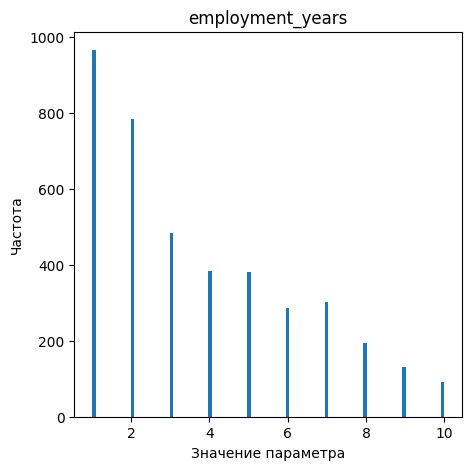

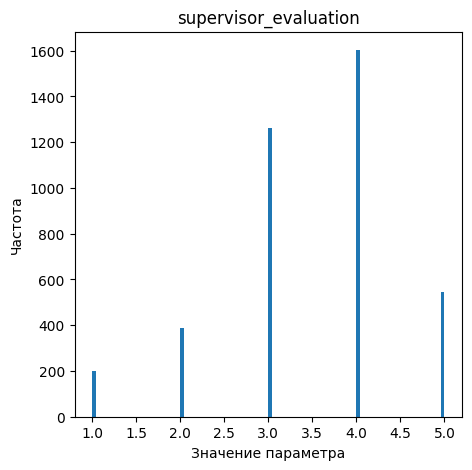

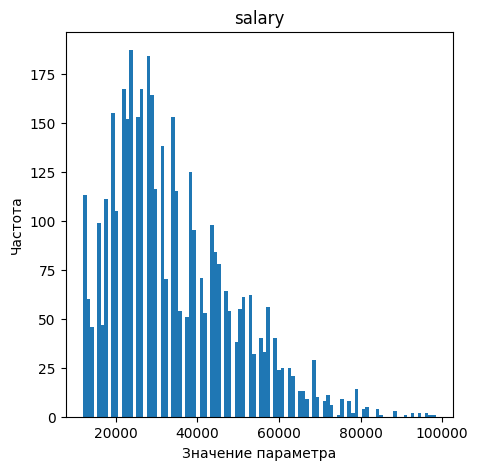

In [23]:
for col in train[num_cols].columns:
    train[col].plot(kind='hist', bins=100, figsize=(5, 5))
    plt.title(col)
    plt.xlabel('Значение параметра')
    plt.ylabel('Частота')
    plt.show()

In [24]:
train.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


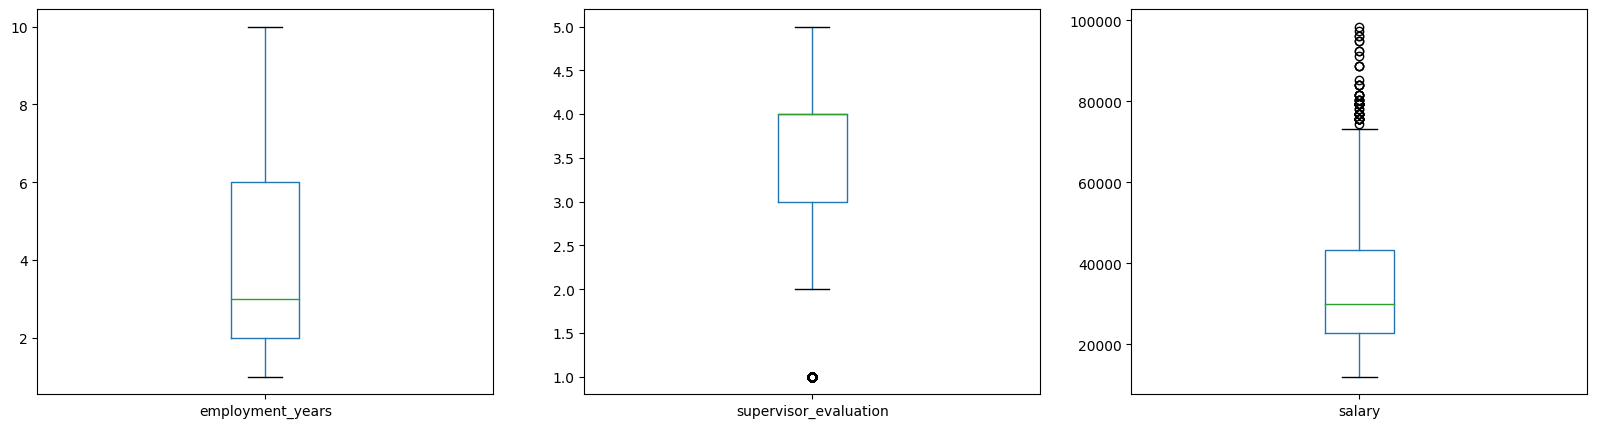

In [25]:
train[num_cols].plot(
    kind='box',
    subplots=True,
    layout=(1, 3),
    figsize=(20,5)
);

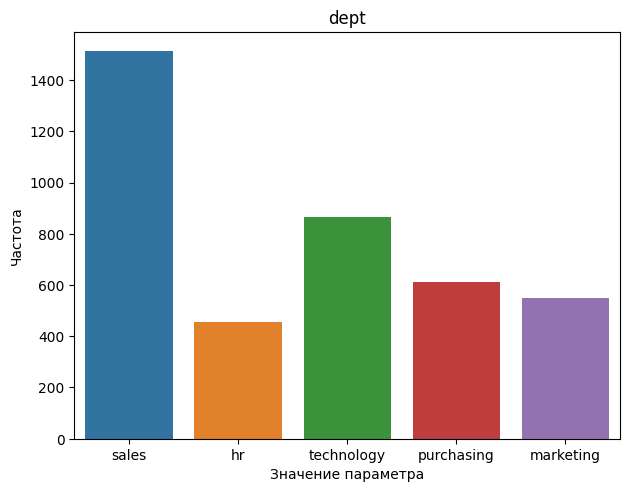

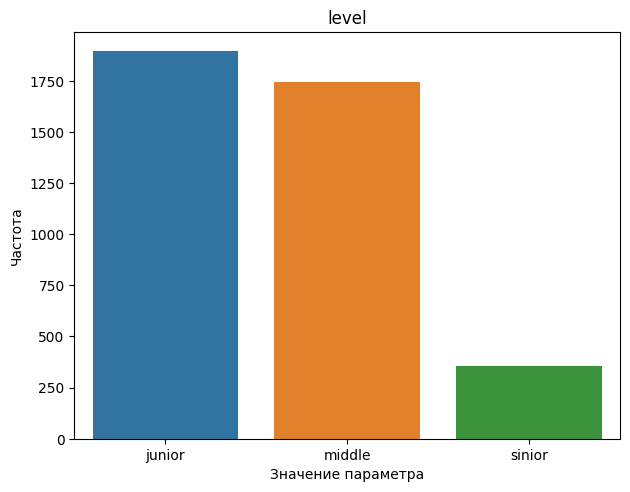

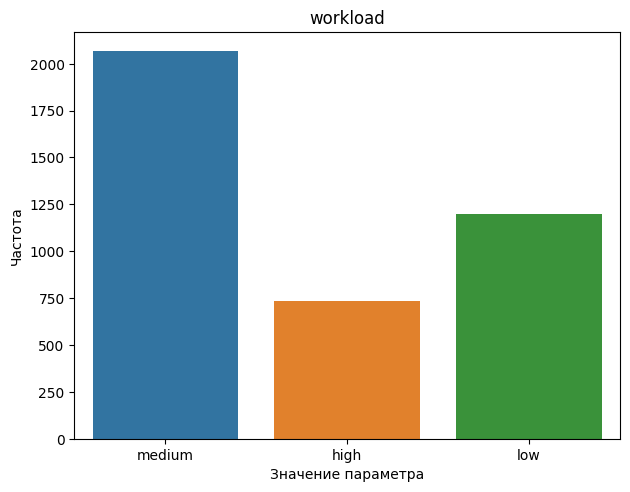

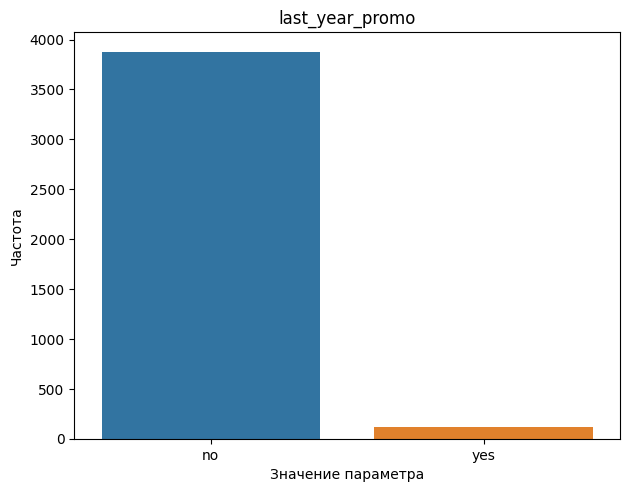

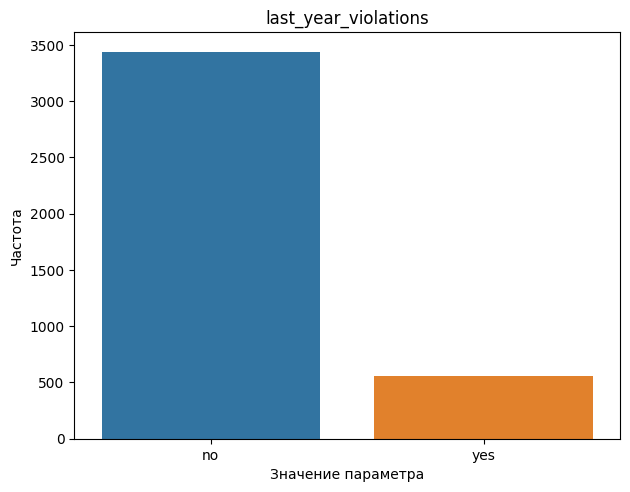

In [26]:
# Категориальные признаки
for col in cat_cols:  
    ax=sns.countplot(x=col, data = train)
    plt.tight_layout()
    plt.title(col)
    plt.xlabel('Значение параметра')
    plt.ylabel('Частота')
    plt.show()

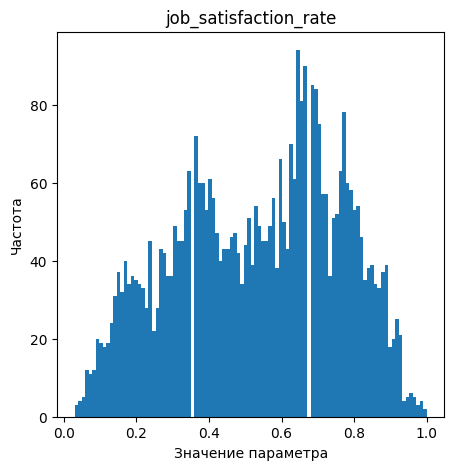

In [27]:
# Распределение целевого признака
train['job_satisfaction_rate'].plot(kind='hist', bins=100, figsize=(5, 5))
plt.title('job_satisfaction_rate')
plt.xlabel('Значение параметра')
plt.ylabel('Частота')
plt.show()

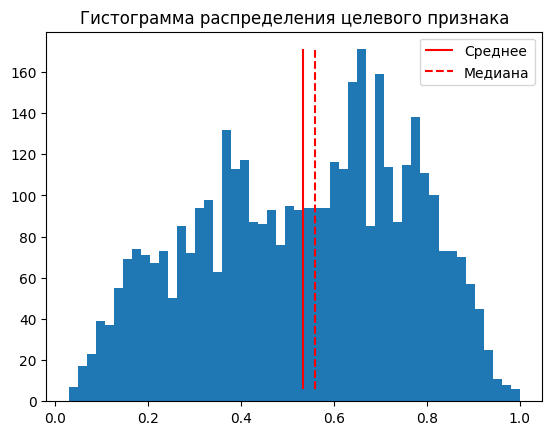

In [28]:
bins = plt.hist(train['job_satisfaction_rate'], bins=50)
plt.vlines(x=train['job_satisfaction_rate'].mean(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), label='Среднее')
plt.vlines(x=train['job_satisfaction_rate'].median(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), linestyles='--', label='Медиана')
plt.title('Гистограмма распределения целевого признака')
plt.legend()
plt.show()

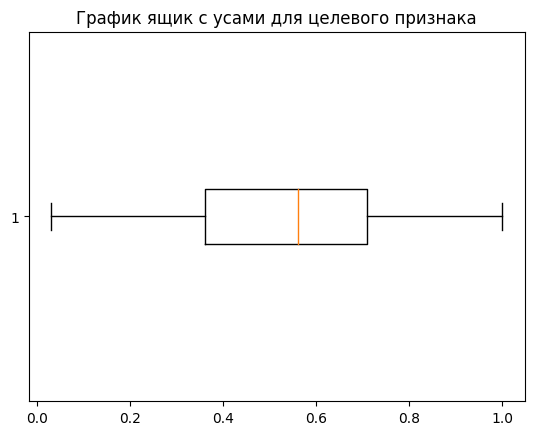

In [29]:
plt.title('График ящик с усами для целевого признака')
plt.boxplot(train['job_satisfaction_rate'], vert=False)
plt.show()

In [30]:
# Корреляционный анализ
train[num_cols+['job_satisfaction_rate']].corr(method='spearman')

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
employment_years,1.000000,-0.001554,0.472688,0.218589
supervisor_evaluation,-0.001554,1.000000,0.003534,0.746608
salary,0.472688,0.003534,1.000000,0.126707
job_satisfaction_rate,0.218589,0.746608,0.126707,1.000000


Очень высоких корреляций (0.9 +) не видно, скорее всего мультиколлинеарности нет

In [31]:
# Построим диграммы рассеяния для признака и всех количественных признаков с учётом значения категориальных признаков.

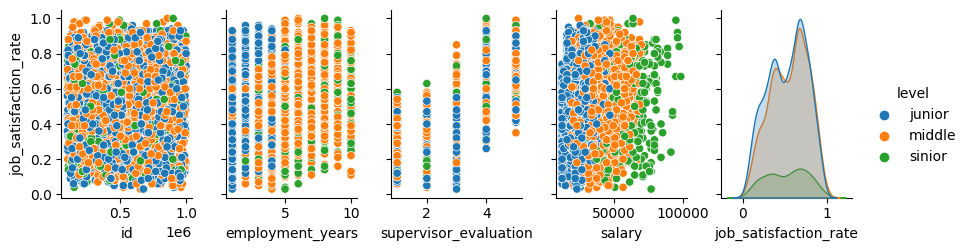

In [32]:
sns.pairplot(data=train, y_vars='job_satisfaction_rate', hue='level', aspect=0.7);

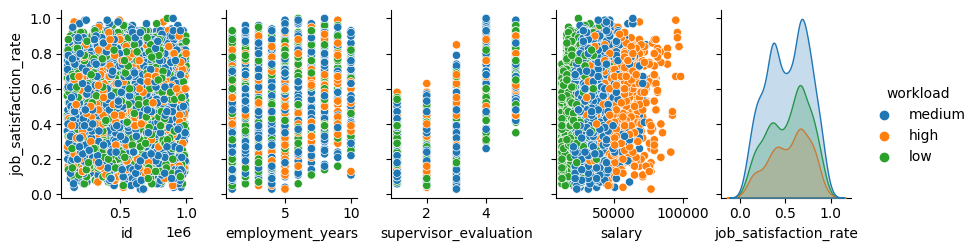

In [33]:
sns.pairplot(data=train, y_vars='job_satisfaction_rate', hue='workload', aspect=0.7);

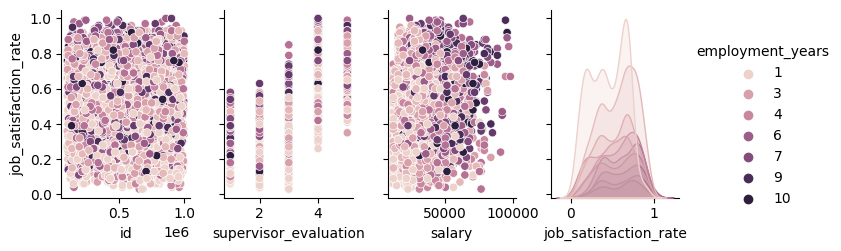

In [34]:
sns.pairplot(data=train, y_vars='job_satisfaction_rate', hue='employment_years', aspect=0.7);

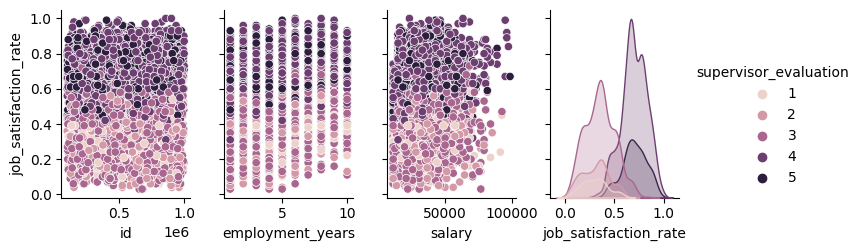

In [35]:
sns.pairplot(data=train, y_vars='job_satisfaction_rate', hue='supervisor_evaluation', aspect=0.7);

В результате статистического анализа вижу:
* признаки employment_years и supervisor_evaluation ранговые котегориальные признаки
* признак salary нормальное распределение со смещением
* признаки 'last_year_promo', 'last_year_violations' неаровномерно распределены 
* целевой признак - вижу бимодальность в данных, среднее значение находится слева от медианы. Это означает, что распределение целевого признака смещено влево, выбросов нет
* на боксплоте salary вижу выбросы
В результате корреляционного анализа 
* очень высоких корреляций (0.9 +) не видно, скорее всего мультиколлинеарности нет
* на диаграммах рассеяния вижу зависимость ранговых категориальных признаков от зарплаты
* зависомость оценки руководителя от удовлетворенности

### Подготовка данных

In [36]:
train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [37]:
# признак 'id' уберем в индекс
train = train.set_index('id')
test = test.set_index('id')
target = target.set_index('id')

In [38]:
# объеденим тестовые признаки и целевой 
test = test.join(target, how='left')
test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


In [39]:
# загружаем данные
X_train = train.drop('job_satisfaction_rate', axis=1)
y_train = train['job_satisfaction_rate']
X_test = test.drop('job_satisfaction_rate', axis=1)
y_test = test['job_satisfaction_rate']

In [40]:
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


In [41]:
y_test.head()

id
485046    0.79
686555    0.72
467458    0.64
418655    0.60
789145    0.75
Name: job_satisfaction_rate, dtype: float64

In [42]:
ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']
ord_cols = ['level', 'workload']
num_cols = ['employment_years', 'supervisor_evaluation', 'salary']

In [43]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', sparse=False)
        )
    ]
)

In [44]:
# SimpleImputer + ORD
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ]
            )
        )
    ]
)

In [45]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
) 

In [46]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

Подготовил признаки в пайплайне.

### Обучение моделей

Первая модель линейная регресия с гиперпараметрами по умолчанию - результат SMAPE = 28.896305693446447

In [47]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_ord',
                                                                   SimpleImputer(stra

In [48]:
predictions1 = pipe_final.predict(X_test)

In [49]:
train_predictions = pipe_final.predict(X_train)

In [50]:
# Написал функцию для расчета метрики SMAPE.
def custom_metric(y_true, y_pred):
    metric = (abs(np.array(y_true).flatten() - np.array(y_pred)) / (
    abs(np.array(y_true).flatten() + np.array(y_pred)) / 2)).sum() * 100 / len(np.array(y_pred))
    return metric

In [51]:
custom_metric(y_test, predictions1)

28.896305693447218

In [52]:
custom_metric(y_train, train_predictions)

39.07417391873398

In [53]:
mean_squared_error(y_test, predictions1)

0.015361046628939933

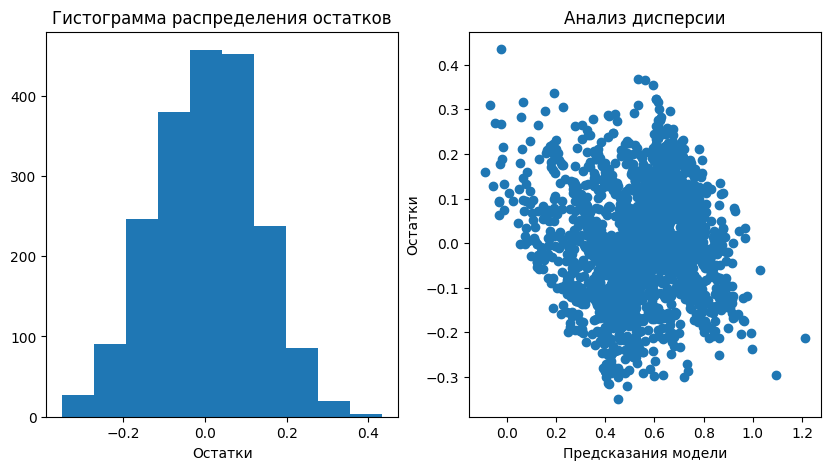

In [54]:
residuals = y_test - predictions1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[1].scatter(x=predictions1, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

<AxesSubplot:ylabel='Feature'>

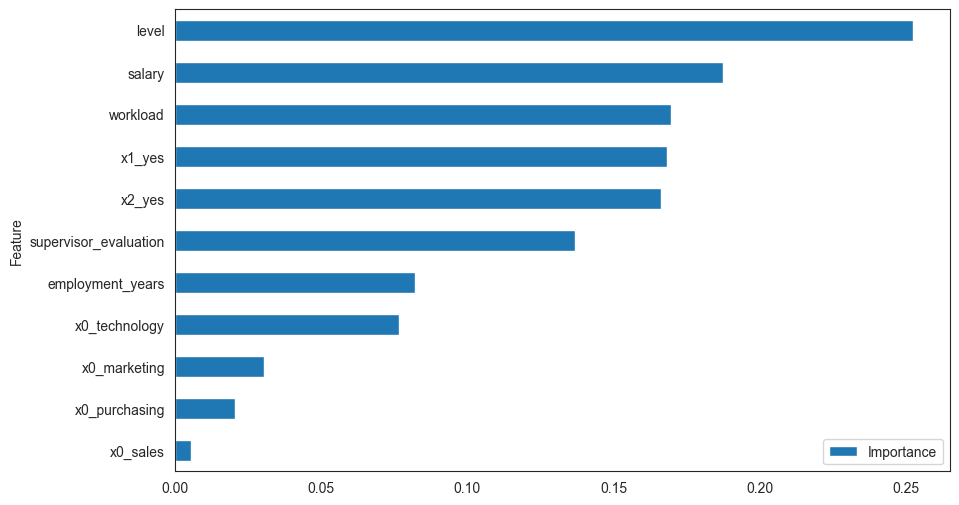

In [55]:
coefficients = pipe_final.named_steps['models'].coef_.tolist()
feature_names = pipe_final.named_steps['preprocessor'].transformers_[0][1][1].get_feature_names().tolist() + ord_cols + num_cols
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

Вторая модель линейная регресия при условии supervisor_evaluation ранговый категориальный признак

In [56]:
ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']
ord_cols = ['level', 'workload', 'supervisor_evaluation']
num_cols = ['employment_years', 'salary']
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', sparse=False)
        )
    ]
)
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],
                    [1, 2, 3, 4, 5]
                ]
            )
        )
    ]
)
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [57]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_ord',
                                                                   SimpleImputer(stra

In [58]:
predictions2 = pipe_final.predict(X_test)
custom_metric(y_test, predictions2)

28.896305693446863

Третья модель DecisionTreeRegressor с max_depth=5

In [59]:
ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']
ord_cols = ['level', 'workload']
num_cols = ['employment_years', 'salary', 'supervisor_evaluation']
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', sparse=False)
        )
    ]
)
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ]
            )
        )
    ]
)
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(
            max_depth=5,
            random_state=RANDOM_STATE
        ))
    ]
)

In [60]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_ord',
                                                                   SimpleImputer(stra

In [61]:
predictions3 = pipe_final.predict(X_test)
custom_metric(y_test, predictions3)

18.805961029820914

In [62]:
mean_squared_error(y_test, predictions3)

0.010185509877671426

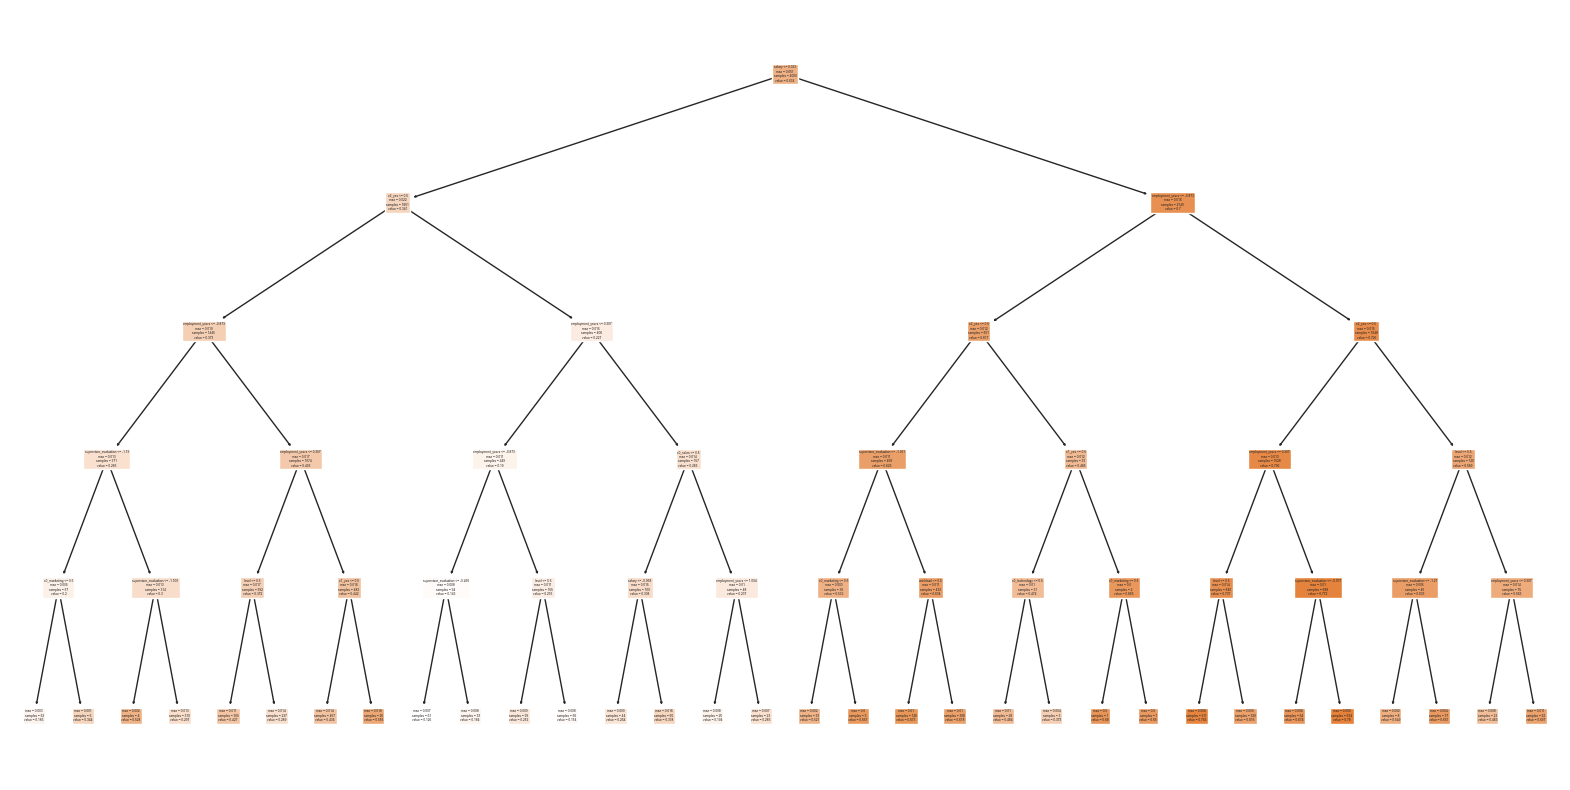

In [63]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(pipe_final.named_steps['models'], feature_names=feature_names, filled=True)
plt.show()

In [64]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, predictions3)

0.010185509877671426

Перебераю гиперпараметры DecisionTreeRegressor(random_state=RANDOM_STATE) max_depth': range(2, 20) и min_samples_leaf': range(2, 20)

In [65]:
ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']
ord_cols = ['level', 'workload']
num_cols = ['employment_years', 'salary', 'supervisor_evaluation']
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', sparse=False)
        )
    ]
)
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ]
            )
        )
    ]
)
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [66]:
param_distributions = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_leaf': range(2, 20)
    },
]

In [67]:
smape_scorer = make_scorer(custom_metric, greater_is_better=False)

In [68]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    #scoring='neg_mean_squared_error',
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [69]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                 

In [70]:
randomized_search.best_score_

-14.792001821164877

In [71]:
predictions4 = randomized_search.predict(X_test)
custom_metric(y_test, predictions4)

14.362497699436688

Первая модель линейная регресия с гиперпараметрами по умолчанию - результат SMAPE = 28.896305693446447.
Провел анализ остатков - нелинейно распределённые остатки. Нарушается свойство постоянства дисперсии.

Вторая модель линейная регресия при условии supervisor_evaluation ранговый категориальный признак - результат такой же.

Третья модель DecisionTreeRegressor с max_depth=5   Результат: 18.805961029820914 Уже лучше, но нужно 15.

Перебераю гиперпараметры DecisionTreeRegressor(random_state=RANDOM_STATE) max_depth': range(2, 20) и min_samples_leaf': range(2, 20) Результат: 14.362497699436688. 

Модель DecisionTreeRegressor max_depth=12, min_samples_leaf=2 подходит критерию успеха: SMAPE ≤15 на тестовой выборке.



### Оформление выводов

Модель Дерево решений лучше справилась с этой задачей. В результате анализа остатков я сделал вывод, что линейная регресия не подходит и нужно искать другие варианты например Дерево решений.

## Задача : предсказание увольнения сотрудника из компании

### Загразка данных

In [72]:
train_quit = pd.read_csv('train_quit.csv')

In [73]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [74]:
train_quit.shape

(4000, 10)

In [75]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [76]:
test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


In [77]:
test.shape

(2000, 9)

In [78]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1997 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               1999 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 220.8+ KB


In [79]:
test_target_quit = pd.read_csv('test_target_quit.csv')

In [80]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [81]:
test_target_quit.shape

(2000, 2)

In [82]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Загрузил данные в датафреймы pandas. Изучил данные. Данные в таблицах соответствуют описанию.

### Предобработка данных

In [83]:
# Поищем явные дубликаты
print(
    train_quit.duplicated().sum(),
    test_target_quit.duplicated().sum(),
)

0 0


In [84]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [85]:
train_quit.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit'],
      dtype='object')

In [86]:
cat_cols = ['dept','level', 'workload', 'last_year_promo', 'last_year_violations']
num_cols = ['employment_years', 'supervisor_evaluation', 'salary']
target_col = 'quit'
for col in cat_cols:
    print(train_quit[col].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']


In [87]:
test_target_quit[target_col].unique()

array(['yes', 'no'], dtype=object)

Дубликатов нет.

### Исследовательский анализ данных

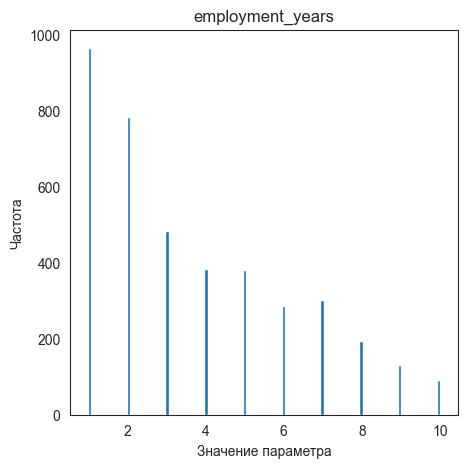

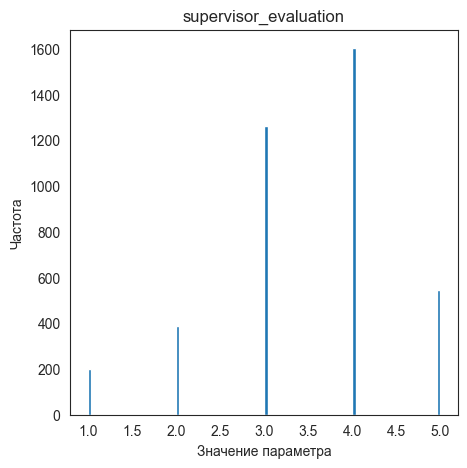

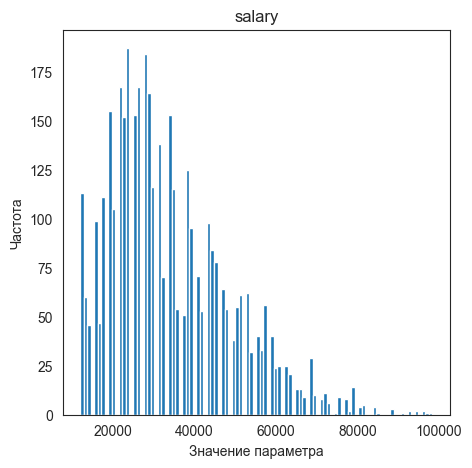

In [88]:
for col in train_quit[num_cols].columns:
    train[col].plot(kind='hist', bins=100, figsize=(5, 5))
    plt.title(col)
    plt.xlabel('Значение параметра')
    plt.ylabel('Частота')
    plt.show()

In [89]:
train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


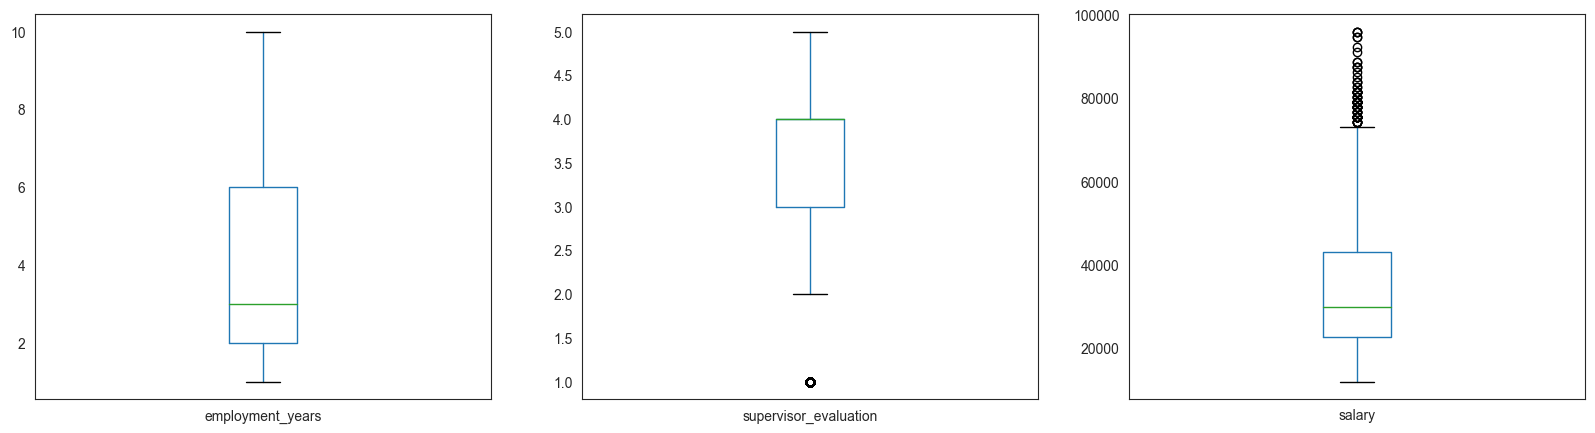

In [90]:
train_quit[num_cols].plot(
    kind='box',
    subplots=True,
    layout=(1, 3),
    figsize=(20,5)
);

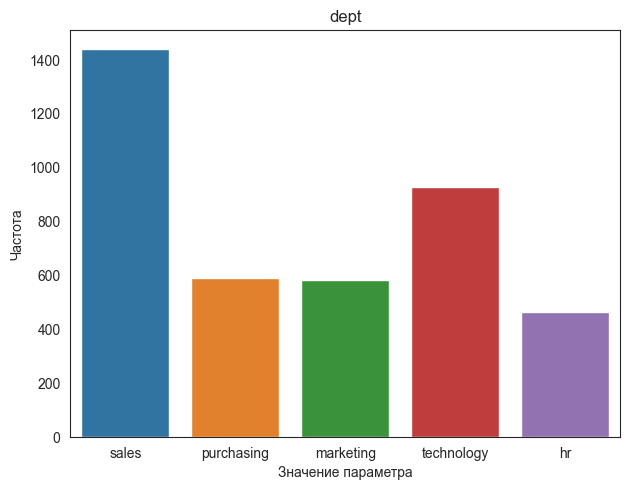

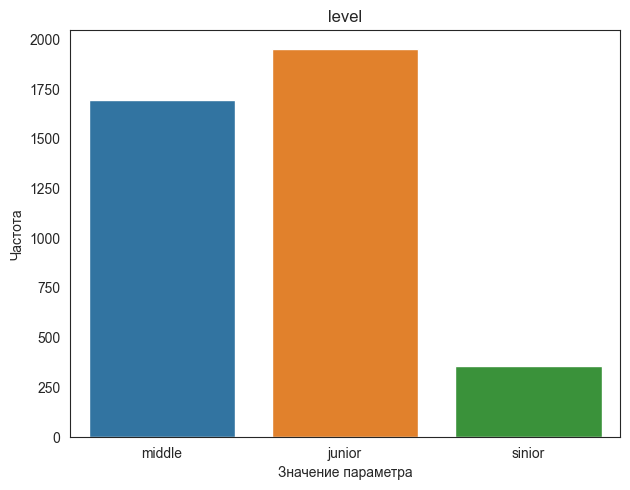

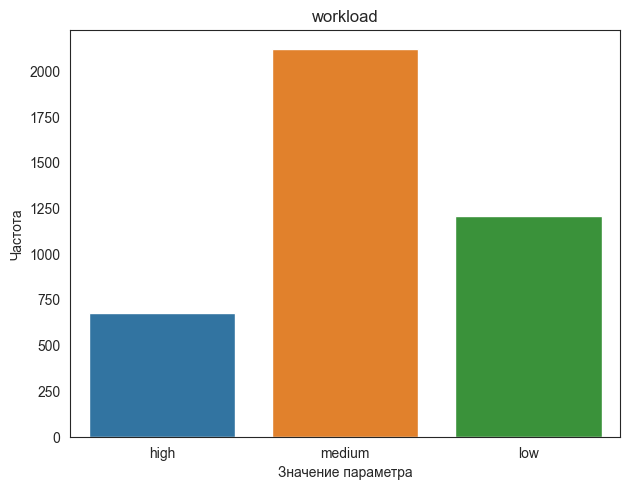

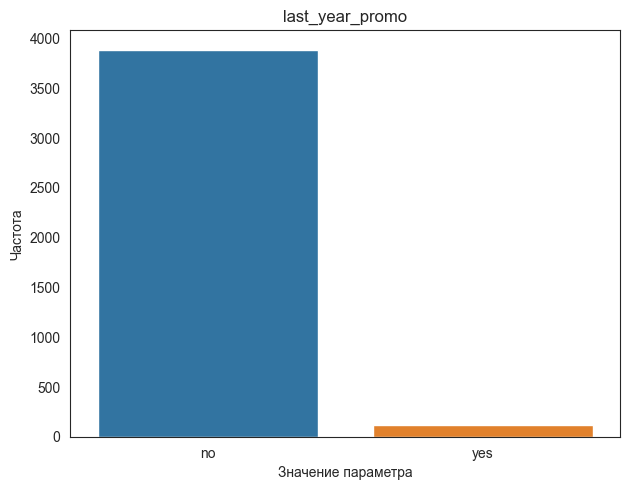

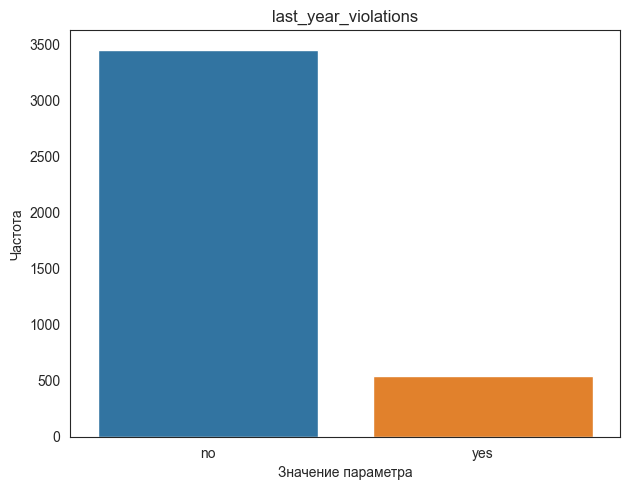

In [91]:
# Категориальные признаки
for col in cat_cols:  
    ax=sns.countplot(x=col, data = train_quit)
    plt.tight_layout()
    plt.title(col)
    plt.xlabel('Значение параметра')
    plt.ylabel('Частота')
    plt.show()

sns.countplot(x='покупательская_активность', data=train_quit);

ax=sns.countplot(x=target, data = train_quit)
plt.tight_layout()
plt.title(target)
plt.xlabel('Значение параметра')
plt.ylabel('Частота')
plt.show()

In [92]:
# Корреляционный анализ
train_quit[num_cols].corr(method='spearman')

,employment_years,supervisor_evaluation,salary
employment_years,1.000000,-0.012320,0.478214
supervisor_evaluation,-0.012320,1.000000,0.033737
salary,0.478214,0.033737,1.000000


Портрет «уволившегося сотрудника»

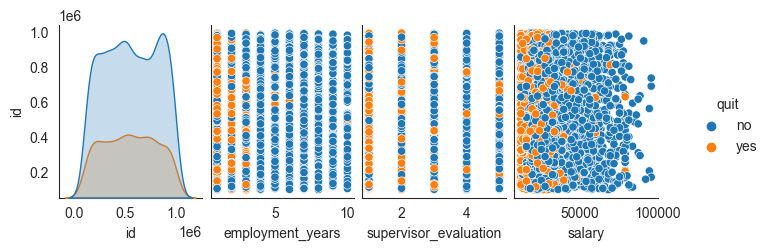

In [93]:
sns.pairplot(data=train_quit, y_vars='id', hue='quit', aspect=0.7);

In [94]:
train_quit.query('salary < 20000').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(train_quit.query('salary < 20000').index)).mul(100)['salary']

quit
no      38.059701
yes     61.940299
All    100.000000
Name: salary, dtype: float64

In [95]:
train_quit.query('employment_years < 3').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(train_quit.query('employment_years < 3').index)).mul(100)['employment_years']

quit
no      49.54597
yes     50.45403
All    100.00000
Name: employment_years, dtype: float64

In [96]:
train_quit.pivot_table(index='quit', columns='dept', values='id', aggfunc=len, margins=True).div(
    len(train_quit.index)).mul(100)

dept,hr,marketing,purchasing,sales,technology,All
quit,,,,,,
no,8.7,10.475,10.55,25.775,16.3,71.8
yes,2.9,4.075,4.15,10.175,6.9,28.2
All,11.6,14.550,14.70,35.950,23.2,100.0


In [97]:
train_quit.query('level == "junior"').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(train_quit.query('level == "junior"').index)).mul(100)['level']

quit
no      48.537712
yes     51.462288
All    100.000000
Name: level, dtype: float64

In [98]:
train_quit.query('workload == "low"').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(train_quit.query('workload == "low"').index)).mul(100)['workload']

quit
no      57.036424
yes     42.963576
All    100.000000
Name: workload, dtype: float64

In [99]:
train_quit.query('last_year_promo == "no"').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(train_quit.query('last_year_promo == "no"').index)).mul(100)['last_year_promo']

quit
no      71.005917
yes     28.994083
All    100.000000
Name: last_year_promo, dtype: float64

In [100]:
train_quit.query('last_year_violations == "yes"').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(train_quit.query('last_year_violations == "yes"').index)).mul(100)['last_year_violations']

quit
no      58.165138
yes     41.834862
All    100.000000
Name: last_year_violations, dtype: float64

In [101]:
train_quit.query('supervisor_evaluation < 4').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(train_quit.query('supervisor_evaluation < 4').index)).mul(100)['supervisor_evaluation']

quit
no      57.174151
yes     42.825849
All    100.000000
Name: supervisor_evaluation, dtype: float64

In [102]:
train_quit.pivot_table(index='quit', columns='dept', aggfunc=len, margins=True).div(
    len(train_quit.index)).mul(100)

employment_years                                                   id  \
dept               hr marketing purchasing   sales technology    All    hr   
quit                                                                         
no                8.7    10.475      10.55  25.775       16.3   71.8   8.7   
yes               2.9     4.075       4.15  10.175        6.9   28.2   2.9   
All              11.6    14.550      14.70  35.950       23.2  100.0  11.6   

                                   ... supervisor_evaluation          \
dept marketing purchasing   sales  ...            purchasing   sales   
quit                               ...                                 
no      10.475      10.55  25.775  ...                 10.55  25.775   
yes      4.075       4.15  10.175  ...                  4.15  10.175   
All     14.550      14.70  35.950  ...                 14.70  35.950   

                       workload                                                 
dept technology    All       hr marketing purchasing   sales technology    All  
quit                                                                            
no         16.3   71.8      8.7    10.475      10.55  25.775       16.3   71.8  
yes         6.9   28.2      2.9     4.075       4.15  10.175        6.9   28.2  
All        23.2  100.0     11.6    14.550      14.70  35.950       23.2  100.0  

[3 rows x 48 columns]

In [103]:
test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


In [104]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [105]:
test_target_quit = test_target_quit.set_index('id')

In [106]:
test = test.join(test_target_quit, how='left')

In [107]:
test.shape

(2000, 10)

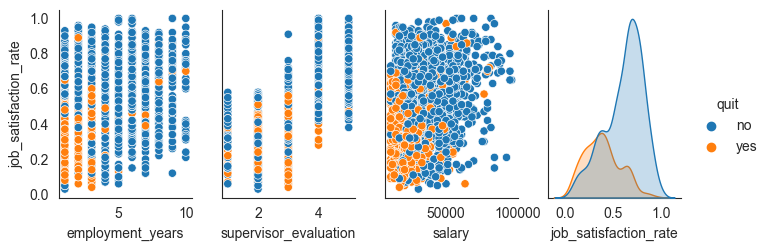

In [108]:
sns.pairplot(data=test, y_vars='job_satisfaction_rate', hue='quit', aspect=0.7);

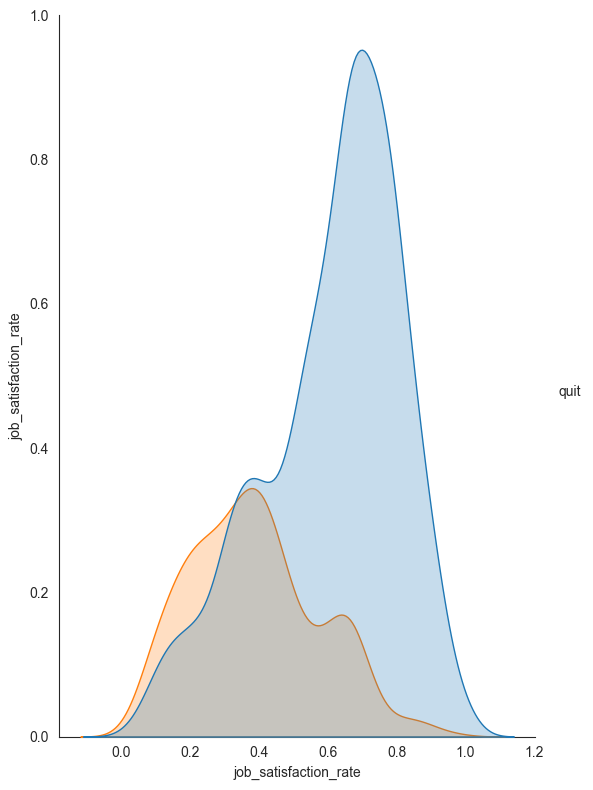

In [109]:
sns.pairplot(data=test[['job_satisfaction_rate', 'quit']], hue='quit', aspect=0.7, height=8, hue_order=['no', 'yes'] );

Об уволившемся сотруднике могу сказать следующее:
* зарплата низкая (ниже 20к). Доля увольнений среди сотрудников с ЗП ниже 20к 61.94%
* проработал 2-3 года. Доля увольнений среди сотрудников со стажем менее 3 лет 50.45%
* имеет низкие оценки руководителя. Доля увольнений среди сотрудников c оценками 1, 2 и 3 - 42.82%
* не зависит от должности. Расрпределение увольнений сотрудников по отделам примерно одинаковое около 25%
* он junior. Доля увольнений среди сотрудников junior 51.46%
* с низкой загруженностью. Доля увольнений среди сотрудников с низкой закгруженностью 42.96%
* без примии. Доля увольнений среди сотрудников без премии 28.99%
* нарушал трудовой договор.  Доля увольнений среди сотрудников нарушевших договор 41.83%

На графике вижу зависимость удовлетворенности сотрудника от статистики увольнения. Распределения оставшихся сотрудников смещено вправо - в сторону высокой удовлетворенности.

### Добавление нового входного признака

In [110]:
train_quit = train_quit.set_index('id')

In [111]:
X_test = train_quit.drop('quit', axis=1)

In [112]:
predictions5 = randomized_search.predict(X_test)
predictions5

array([0.65761905, 0.82209302, 0.36      , ..., 0.56      , 0.55333333,
       0.53      ])

In [113]:
train_quit['job_satisfaction_rate'] = predictions5

In [114]:
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000
814010,sales,junior,medium,2,no,no,4,27600
155091,purchasing,middle,medium,5,no,no,1,37200
257132,sales,junior,medium,2,no,yes,3,24000
910140,marketing,junior,medium,2,no,no,5,25200


In [115]:
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.657619
814010,sales,junior,medium,2,no,no,4,27600,no,0.822093
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.360000
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.812500


In [116]:
train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


Добавил предсказанный лучшей моделью первой задачи признак job_satisfaction_rate к входным признакам второй задачи.

### Подготовка данных

In [117]:
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.657619
814010,sales,junior,medium,2,no,no,4,27600,no,0.822093
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.360000
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.812500


In [118]:
test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
686555,hr,junior,medium,1,no,no,4,30000,0.72,no
467458,sales,middle,low,5,no,no,4,19200,0.64,no
418655,sales,middle,low,6,no,no,4,19200,0.60,no
789145,hr,middle,medium,5,no,no,5,40800,0.75,no


In [119]:
# загружаем данные
X_train = train_quit.drop('quit', axis=1)
y_train = train_quit['quit']
X_test = test.drop('quit', axis=1)
y_test = test['quit']

In [120]:
ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']
ord_cols = ['level', 'workload']
num_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [121]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', sparse=False)
        )
    ]
)

In [122]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ]
            )
        )
    ]
)

In [123]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
) 

In [124]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

Подготовил признаки в пайплайне.

### Обучение модели

Обучил модель LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1', max_iter=100)

In [125]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1', max_iter=100))
    ]
)

In [126]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_ord',
                                                                   SimpleImputer(stra

In [127]:
y_pred = pipe_final.predict(X_test)
probabilities = pipe_final.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.9105943420454768


Модель DecisionTreeClassifier(random_state=RANDOM_STATE)

In [128]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [129]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_ord',
                                                                   SimpleImputer(stra

In [130]:
y_pred = pipe_final.predict(X_test)
probabilities = pipe_final.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.8607044785554832


Модель KNeighborsClassifier(n_neighbors=5)

In [131]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', KNeighborsClassifier(n_neighbors=5))
    ]
)

In [132]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_ord',
                                                                   SimpleImputer(stra

In [133]:
probabilities = pipe_final.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.9132940447262885


In [134]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
) 
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

In [135]:
# подготовка данных
param_grid = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1', max_iter=100)],
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 12),
        'models__max_features': range(2, 12),
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 12),
    }
]

In [136]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_ord',
                                                     

In [137]:
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.9214042651968628


* Обучил модель LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1', max_iter=100) Результат: Площадь ROC-кривой: 0.0.9105943420454768 . Результат удовлетворяет заявленому.
* Модель DecisionTreeClassifier(random_state=RANDOM_STATE) Результат: 0.868694314387878. Мало нужно 0,91
* Модель KNeighborsClassifier(n_neighbors=5) Результат:   0.9132940447262885
* Перебераю гиперпараметры на трех моделях. Лучший результат 0.9214042651968628 Модель DecisionTreeClassifier(max_depth=5, max_features=11)

### Выводы

Модель Дерево решений опять лучше всего справилось с задачей. Видимо это модель большего всего подходит для конкретно этих данных.

# Общий вывод

Целями проекта являются построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика и построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Я агрузил данные в датафреймы pandas. Изучил данные. Вижу нулевые значение признаков 10 шт в тренеровочной и 3 шт в тестовой выборке. Данные в таблицах соответствуют описанию. Провел предобработку данных и исследовательский анализ:

В результате статистического анализа вижу:
* признаки employment_years и supervisor_evaluation ранговые котегориальные признаки
* признак salary нормальное распределение со смещением
* признаки 'last_year_promo', 'last_year_violations' неаровномерно распределены 
* целевой признак - вижу бимодальность в данных, среднее значение находится слева от медианы. Это означает, что распределение целевого признака смещено влево, выбросов нет
* на боксплоте salary вижу выбросы
В результате корреляционного анализа 
* очень высоких корреляций (0.9 +) не видно, скорее всего мультиколлинеарности нет
* на диаграммах рассеяния вижу зависимость ранговых категориальных признаков от зарплаты
* зависомость оценки руководителя от удовлетворенности

Модель DecisionTreeRegressor max_depth=12, min_samples_leaf=2 подходит критерию успеха: SMAPE ≤15 на тестовой выборке.

Обучил лучшую модель для задачи построить модель, которая сможет предсказать уровень удовлетворённости сотрудника. Модель DecisionTreeRegressor max_depth=12, min_samples_leaf=2 с результатом SMAPE=14.36. 
В результате работы модели получил дополнительный признак для задачи построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
Обучил лучшую модель. Лучший результат 0.923886040814713 Модель DecisionTreeClassifier(max_depth=5, max_features=11)
Модель Дерево решений опять лучше всего справилось с задачей.

Бизнесу предлагаю рабочую модель для выявления сотрудников, которые могут уволится. Также для выевления и стимулирования сотрудников поможет созданныей портрет:

* зарплата низкая (ниже 20к). Доля увольнений среди сотрудников с ЗП ниже 20к 61.94%
* проработал 2-3 года. Доля увольнений среди сотрудников со стажем менее 3 лет 50.45%
* имеет низкие оценки руководителя. Доля увольнений среди сотрудников c оценками 1, 2 и 3 - 42.82%
* не зависит от должности. Расрпределение увольнений сотрудников по отделам примерно одинаковое около 25%
* он junior. Доля увольнений среди сотрудников junior 51.46%
* с низкой загруженностью. Доля увольнений среди сотрудников с низкой закгруженностью 42.96%
* без примии. Доля увольнений среди сотрудников без премии 28.99%
* нарушал трудовой договор.  Доля увольнений среди сотрудников нарушевших договор 41.83%